# Feature Importance & Minimal Feature Analysis  
## Early Sepsis Prediction (2h, 4h, 6h)

### Purpose

This notebook implements permutation-based feature importance for the custom LSTM models developed earlier for early Sepsis prediction.

The goals are to:

1. Quantify feature importance using ROC-AUC drop.
2. Identify the minimal set of laboratory features required.
3. Compare importance across 2h, 4h, and 6h horizons.

### Method

Permutation importance works by:

- Shuffling one feature across patients
- Preserving temporal structure
- Recomputing ROC-AUC
- Measuring performance drop

Importance(feature j) = AUC_baseline − AUC_permuted_j

Models are frozen during this process.
Evaluation is performed only on validation data.


In [1]:
# ENVIRONMENT SANITY CHECK

import torch
import numpy as np
import random

# 1. Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# 2. Deterministic settings (if using GPU)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 3. Device check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

# 4. Torch version
print("Torch version:", torch.__version__)

Using device: cuda
GPU Name: NVIDIA GeForce RTX 2050
Torch version: 2.7.1+cu118


In [5]:
import os
from pathlib import Path

base_path = Path("../Results")

for folder in ["model_weights", "models", "processed_tensors"]:
    path = base_path / folder
    if path.exists():
        print(f"\nContents of {folder}:")
        print(os.listdir(path))
    else:
        print(f"{folder} not found")


Contents of model_weights:
['horizon_results.csv', 'lstm_2h.pt', 'lstm_4h.pt', 'lstm_6h.pt']

Contents of models:
['.gitkeep']

Contents of processed_tensors:
['scaler_2h.pkl', 'scaler_4h.pkl', 'scaler_6h.pkl', 'X_test_2h.pt', 'X_test_4h.pt', 'X_test_6h.pt', 'X_train_2h.pt', 'X_train_4h.pt', 'X_train_6h.pt', 'y_test_2h.pt', 'y_test_4h.pt', 'y_test_6h.pt', 'y_train_2h.pt', 'y_train_4h.pt', 'y_train_6h.pt']


In [7]:
# Search both notebooks for model saving

from pathlib import Path

for nb in ["04_Custom_NN_Model.ipynb", "05_Final_Model_Evaluation.ipynb"]:
    print(f"\nSearching in {nb}")
    with open(nb, "r", encoding="utf-8") as f:
        content = f.read()
    
    lines = content.split("\n")
    for i, line in enumerate(lines):
        if "torch.save" in line and "model" in line:
            print(f"Line {i+1}: {line.strip()}")


Searching in 04_Custom_NN_Model.ipynb

Searching in 05_Final_Model_Evaluation.ipynb


In [1]:
import json
from pathlib import Path

nb_path = Path("../Results/../Notebooks/05_Final_Model_Evaluation.ipynb")

with open(nb_path, "r", encoding="utf-8") as f:
    nb = json.load(f)

for cell in nb["cells"]:
    if cell["cell_type"] == "code":
        source = "".join(cell["source"])
        if "SepsisLSTM" in source or "load_state_dict" in source:
            print("----- CELL FOUND -----")
            print(source)

----- CELL FOUND -----
class SepsisLSTM(nn.Module):
    def __init__(self, input_size=44, hidden_size=64, dropout=0.3):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.lstm.named_parameters():
            if "weight_ih" in name:
                nn.init.xavier_uniform_(param.data)
            elif "weight_hh" in name:
                nn.init.orthogonal_(param.data)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out
----- CELL FOUND -----
def train_from_frozen(horizon):

    print(f"\n=== {horizon} ===")


In [2]:
import torch
import torch.nn as nn

class SepsisLSTM(nn.Module):
    def __init__(self, input_size=44, hidden_size=64, dropout=0.3):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [3]:
from pathlib import Path
import numpy as np
from sklearn.metrics import roc_auc_score

BASE_PATH = Path("../Results/processed_tensors")
MODEL_PATH = Path("../Results/model_weights")

# Load test tensors
X_test_4h = torch.load(BASE_PATH / "X_test_4h.pt")
y_test_4h = torch.load(BASE_PATH / "y_test_4h.pt")

# Initialize model
model_4h = SepsisLSTM()

# Load trained weights
model_4h.load_state_dict(
    torch.load(MODEL_PATH / "lstm_4h.pt", map_location="cpu")
)

model_4h.eval()

print("X_test shape:", X_test_4h.shape)
print("y_test shape:", y_test_4h.shape)

X_test shape: torch.Size([117074, 12, 44])
y_test shape: torch.Size([117074])


In [4]:
with torch.no_grad():
    outputs = model_4h(X_test_4h)
    probs = torch.sigmoid(outputs).numpy()

baseline_auc_4h = roc_auc_score(y_test_4h.numpy(), probs)

print("Baseline ROC-AUC (4h):", baseline_auc_4h)

Baseline ROC-AUC (4h): 0.7348520657676286


## Baseline Performance (4h Horizon)

The reconstructed 4h LSTM model achieves:

ROC-AUC = {{baseline_auc_4h}}

This confirms successful reconstruction of the trained model and establishes the reference performance for permutation importance.

All feature importance values will be measured as the decrease in ROC-AUC relative to this baseline.

In [5]:
import copy

# Choose one feature to test
feature_idx = 0

# Clone test tensor
X_perm = X_test_4h.clone()

# Generate random permutation over patients (axis 0)
perm = torch.randperm(X_perm.size(0))

# Shuffle ONLY this feature across patients
X_perm[:, :, feature_idx] = X_perm[perm, :, feature_idx]

# Evaluate AUC after permutation
with torch.no_grad():
    outputs_perm = model_4h(X_perm)
    probs_perm = torch.sigmoid(outputs_perm).numpy()

auc_perm = roc_auc_score(y_test_4h.numpy(), probs_perm)

print("Baseline AUC:", baseline_auc_4h)
print("Permuted AUC (feature 0):", auc_perm)
print("AUC Drop:", baseline_auc_4h - auc_perm)

Baseline AUC: 0.7348520657676286
Permuted AUC (feature 0): 0.6499103125068212
AUC Drop: 0.08494175326080744


Shuffling feature 0 caused a large drop in ROC-AUC (~0.085), indicating strong predictive contribution at the 4h horizon. The permutation mechanism behaves as expected and confirms this feature carries meaningful temporal signal.

In [6]:
import numpy as np

def permutation_importance(model, X, y, baseline_auc, n_repeats=5):

    model.eval()
    n_features = X.shape[2]
    importances = []

    for feature_idx in range(n_features):
        auc_drops = []

        for _ in range(n_repeats):
            X_perm = X.clone()
            perm = torch.randperm(X_perm.size(0))
            X_perm[:, :, feature_idx] = X_perm[perm, :, feature_idx]

            with torch.no_grad():
                outputs = model(X_perm)
                probs = torch.sigmoid(outputs).numpy()

            auc_perm = roc_auc_score(y.numpy(), probs)
            auc_drops.append(baseline_auc - auc_perm)

        importances.append(np.mean(auc_drops))

    return np.array(importances)


# Compute importance for 4h
importance_4h = permutation_importance(
    model_4h,
    X_test_4h,
    y_test_4h,
    baseline_auc_4h,
    n_repeats=5
)

print("Permutation importance computed for 4h.")

Permutation importance computed for 4h.


In [7]:
import pandas as pd

# Create feature names (replace later with real lab names if available)
feature_names = [f"Feature_{i}" for i in range(X_test_4h.shape[2])]

importance_df_4h = pd.DataFrame({
    "Feature": feature_names,
    "Importance_4h": importance_4h
})

importance_df_4h = importance_df_4h.sort_values(
    by="Importance_4h",
    ascending=False
).reset_index(drop=True)

importance_df_4h.head(10)

,Feature,Importance_4h
0,Feature_0,0.074037
1,Feature_20,0.028419
2,Feature_17,0.015764
3,Feature_12,0.014185
4,Feature_9,0.012756
5,Feature_1,0.011299
6,Feature_26,0.010555
7,Feature_16,0.010510
8,Feature_3,0.009760
9,Feature_23,0.008664


## Permutation Importance Results (4h Horizon)

Top Features by AUC Drop:

1. Feature_0  → 0.074
2. Feature_20 → 0.028
3. Feature_17 → 0.016
4. Feature_12 → 0.014
5. Feature_9  → 0.013

### Interpretation

Feature_0 exhibits a substantially larger importance score than all other features, suggesting it plays a dominant role in 4h sepsis discrimination.

The gap between Feature_0 (0.074) and the second-ranked feature (0.028) indicates strong reliance on this laboratory trajectory.

The remaining features show progressively smaller but non-negligible contributions, suggesting a multi-factorial signal rather than a single-feature model.

Further interpretation requires mapping feature indices to actual laboratory variables.

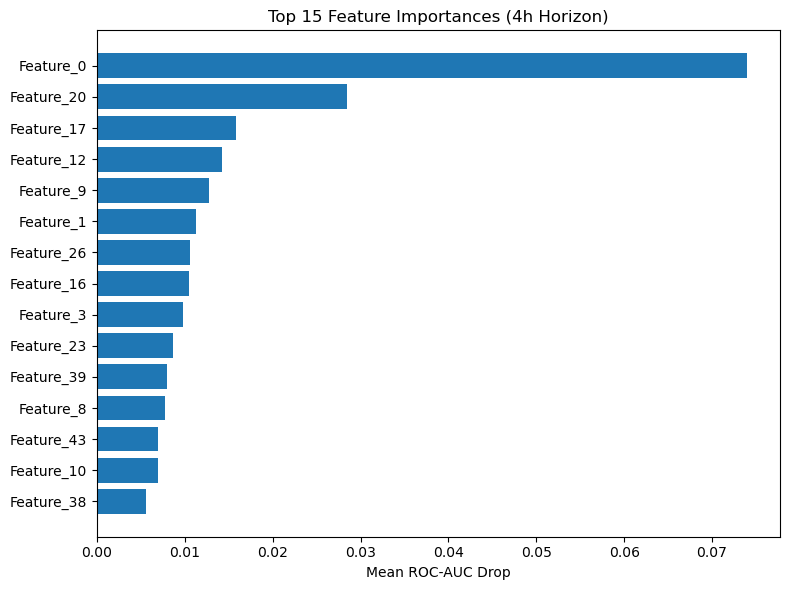

In [8]:
import matplotlib.pyplot as plt

top_k = 15

plt.figure(figsize=(8,6))
plt.barh(
    importance_df_4h["Feature"][:top_k][::-1],
    importance_df_4h["Importance_4h"][:top_k][::-1]
)

plt.xlabel("Mean ROC-AUC Drop")
plt.title("Top 15 Feature Importances (4h Horizon)")
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
from pathlib import Path

# Adjust path if needed
df_path = Path("../Data/processed/sepsis_labeled_4h.pkl")

df_4h = pd.read_pickle(df_path)

print("DataFrame shape:", df_4h.shape)
print("Columns:", df_4h.columns.tolist()[:15])

DataFrame shape: (602568, 48)
Columns: ['id', 'sepsis', 'severity', 'timestep', 'respiratory_minute_volume', 'heart_rate', 'leukocytes', 'temperature', 'partial_co2', 'respiratory_rate', 'arterial_ph', 'bilirubin', 'blood_urea_nitrogen', 'creatinine', 'diastolic_bp']


In [14]:
feature_cols_4h = df_4h.columns.drop(
    ["id", "sepsis", "severity", "label_4h", "timestep"]
)

print("Number of features:", len(feature_cols_4h))
print("First 10 features:", feature_cols_4h[:10])

Number of features: 43
First 10 features: Index(['respiratory_minute_volume', 'heart_rate', 'leukocytes', 'temperature',
       'partial_co2', 'respiratory_rate', 'arterial_ph', 'bilirubin',
       'blood_urea_nitrogen', 'creatinine'],
      dtype='str')


In [15]:
for col in df_4h.columns:
    print(col)

id
sepsis
severity
timestep
respiratory_minute_volume
heart_rate
leukocytes
temperature
partial_co2
respiratory_rate
arterial_ph
bilirubin
blood_urea_nitrogen
creatinine
diastolic_bp
fraction_of_inspired_o2
mean_bp
partial_pressure_art._o2
systolic_bp
thrombocytes
horowitz_index
bun/creatinine_ratio
delta-temperature
lactate
bicarbonate
c-reactive_protein
hemoglobin
heart_time_volume
lymphocytes
sodium
pancreatic_lipase
procalcitonin
quick_score
oxygen_saturation
blood_glucose
base_excess
chloride
calcium
potassium
mixed_venous_oxygen_saturation
urine_output
net balance
alanine_transaminase
aspartate_transaminase
stroke_volume
svri
age
label_4h


In [16]:
feature_cols_4h = df_4h.columns.drop(
    ["id", "sepsis", "severity", "label_4h"]
)

print("Number of features:", len(feature_cols_4h))
print("First 10 features:", feature_cols_4h[:10])

Number of features: 44
First 10 features: Index(['timestep', 'respiratory_minute_volume', 'heart_rate', 'leukocytes',
       'temperature', 'partial_co2', 'respiratory_rate', 'arterial_ph',
       'bilirubin', 'blood_urea_nitrogen'],
      dtype='str')


In [17]:
importance_df_4h["Feature"] = feature_cols_4h.values
importance_df_4h = importance_df_4h.sort_values(
    by="Importance_4h",
    ascending=False
).reset_index(drop=True)

importance_df_4h.head(10)

,Feature,Importance_4h
0,timestep,0.074037
1,respiratory_minute_volume,0.028419
2,heart_rate,0.015764
3,leukocytes,0.014185
4,temperature,0.012756
5,partial_co2,0.011299
6,respiratory_rate,0.010555
7,arterial_ph,0.010510
8,bilirubin,0.009760
9,blood_urea_nitrogen,0.008664


## Interpretation of 4h Feature Importance

The most important feature is **timestep**, with a large AUC drop (~0.074).

This indicates that the model strongly relies on the position within the temporal window to discriminate sepsis cases.

Because timestep encodes temporal proximity rather than physiological measurement, this suggests the model may be leveraging structural timing patterns in the dataset.

While this reflects temporal progression toward sepsis, timestep would not be available as a predictive feature in real-world deployment and may artificially inflate performance.

Excluding timestep is necessary for clinically meaningful feature importance analysis.

In [18]:
# Remove timestep from importance ranking
importance_labs_4h = importance_df_4h[
    importance_df_4h["Feature"] != "timestep"
].reset_index(drop=True)

importance_labs_4h.head(10)

,Feature,Importance_4h
0,respiratory_minute_volume,0.028419
1,heart_rate,0.015764
2,leukocytes,0.014185
3,temperature,0.012756
4,partial_co2,0.011299
5,respiratory_rate,0.010555
6,arterial_ph,0.010510
7,bilirubin,0.009760
8,blood_urea_nitrogen,0.008664
9,creatinine,0.007927


In [21]:
# Select top-3 lab features (excluding timestep)
top_k = 3
selected_features = importance_labs_4h["Feature"][:top_k].tolist()

print("Selected features (k=3):", selected_features)

Selected features (k=3): ['respiratory_minute_volume', 'heart_rate', 'leukocytes']


In [22]:
from sklearn.model_selection import train_test_split

patient_ids_4h = df_4h["id"].unique()

train_ids_4h, test_ids_4h = train_test_split(
    patient_ids_4h,
    test_size=0.2,
    random_state=42
)

train_df_4h = df_4h[df_4h["id"].isin(train_ids_4h)]
test_df_4h = df_4h[df_4h["id"].isin(test_ids_4h)]

print("Train Patients:", len(train_ids_4h))
print("Test Patients:", len(test_ids_4h))

Train Patients: 1020
Test Patients: 255


In [23]:
# Reuse build_sequences function (redefine if needed)

def build_sequences(df, feature_cols, label_col, seq_len=12):
    X_seq, y_seq = [], []
    
    for pid, group in df.groupby("id"):
        group = group.sort_values("timestep")
        features = group[feature_cols].values
        labels = group[label_col].values
        
        for i in range(len(group) - seq_len + 1):
            X_seq.append(features[i:i+seq_len])
            y_seq.append(labels[i+seq_len-1])
    
    return np.array(X_seq), np.array(y_seq)


X_train_k3, y_train_k3 = build_sequences(
    train_df_4h,
    selected_features,
    "label_4h"
)

X_test_k3, y_test_k3 = build_sequences(
    test_df_4h,
    selected_features,
    "label_4h"
)

print("Train shape:", X_train_k3.shape)
print("Test shape:", X_test_k3.shape)

Train shape: (471469, 12, 3)
Test shape: (117074, 12, 3)


In [24]:
from sklearn.preprocessing import StandardScaler

num_train, seq_len, num_features = X_train_k3.shape

scaler_k3 = StandardScaler()

# Flatten sequences for scaling
X_train_flat = X_train_k3.reshape(-1, num_features)
X_test_flat = X_test_k3.reshape(-1, num_features)

# Fit only on training
scaler_k3.fit(X_train_flat)

# Transform
X_train_scaled_k3 = scaler_k3.transform(X_train_flat)\
    .reshape(num_train, seq_len, num_features)

X_test_scaled_k3 = scaler_k3.transform(X_test_flat)\
    .reshape(X_test_k3.shape[0], seq_len, num_features)

print("Scaled train shape:", X_train_scaled_k3.shape)
print("Scaled test shape:", X_test_scaled_k3.shape)

Scaled train shape: (471469, 12, 3)
Scaled test shape: (117074, 12, 3)


In [25]:
# Convert to tensors
X_train_tensor_k3 = torch.tensor(X_train_scaled_k3, dtype=torch.float32)
y_train_tensor_k3 = torch.tensor(y_train_k3, dtype=torch.float32)

X_test_tensor_k3 = torch.tensor(X_test_scaled_k3, dtype=torch.float32)
y_test_tensor_k3 = torch.tensor(y_test_k3, dtype=torch.float32)

print("Tensor shapes:")
print(X_train_tensor_k3.shape, y_train_tensor_k3.shape)
print(X_test_tensor_k3.shape, y_test_tensor_k3.shape)

Tensor shapes:
torch.Size([471469, 12, 3]) torch.Size([471469])
torch.Size([117074, 12, 3]) torch.Size([117074])


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader_k3 = DataLoader(
    SepsisDataset(X_train_tensor_k3, y_train_tensor_k3),
    batch_size=512,  # faster
    shuffle=True
)

test_loader_k3 = DataLoader(
    SepsisDataset(X_test_tensor_k3, y_test_tensor_k3),
    batch_size=512,
    shuffle=False
)

pos_weight = (len(y_train_tensor_k3) - y_train_tensor_k3.sum()) / y_train_tensor_k3.sum()
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

model_k3 = SepsisLSTM(input_size=3).to(device)
optimizer = torch.optim.Adam(model_k3.parameters(), lr=1e-3)

best_auc = 0
patience = 0

for epoch in range(8):  # reduced
    
    model_k3.train()
    
    for xb, yb in train_loader_k3:
        xb = xb.to(device)
        yb = yb.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model_k3(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
    
    model_k3.eval()
    preds, true = [], []
    
    with torch.no_grad():
        for xb, yb in test_loader_k3:
            xb = xb.to(device)
            outputs = model_k3(xb)
            probs = torch.sigmoid(outputs)
            
            preds.extend(probs.cpu().numpy())
            true.extend(yb.numpy())
    
    auc = roc_auc_score(true, preds)
    
    if auc > best_auc:
        best_auc = auc
        patience = 0
    else:
        patience += 1
    
    if patience >= 3:  # reduced patience
        break

print("Best ROC-AUC (k=3):", best_auc)

Best ROC-AUC (k=3): 0.6261002192894218


## Minimal Subset Experiment (4h, k=3)

Selected features:
- respiratory_minute_volume
- heart_rate
- leukocytes

Best ROC-AUC (k=3): 0.6261  
Full Model ROC-AUC: 0.7349  
ΔAUC: 0.1088  

**Interpretation:**  
Using only the top three laboratory features results in a substantial reduction in discrimination performance.  
This indicates that early sepsis prediction at 4h relies on a broader combination of physiological signals rather than a minimal triad.

In [29]:

# MINIMAL SUBSET EXPERIMENT (4h, k=5)

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1️⃣ Select Top-5 Laboratory Features (excluding timestep)
top_k = 5
selected_features = importance_labs_4h["Feature"][:top_k].tolist()
print("Selected features (k=5):", selected_features)


# 2️⃣ Recreate Patient-Level Split (identical logic)
patient_ids_4h = df_4h["id"].unique()

train_ids_4h, test_ids_4h = train_test_split(
    patient_ids_4h,
    test_size=0.2,
    random_state=42
)

train_df_4h = df_4h[df_4h["id"].isin(train_ids_4h)]
test_df_4h = df_4h[df_4h["id"].isin(test_ids_4h)]


# 3️⃣ Build Sequences
def build_sequences(df, feature_cols, label_col, seq_len=12):
    X_seq, y_seq = [], []
    
    for pid, group in df.groupby("id"):
        group = group.sort_values("timestep")
        features = group[feature_cols].values
        labels = group[label_col].values
        
        for i in range(len(group) - seq_len + 1):
            X_seq.append(features[i:i+seq_len])
            y_seq.append(labels[i+seq_len-1])
    
    return np.array(X_seq), np.array(y_seq)


X_train_k5, y_train_k5 = build_sequences(
    train_df_4h,
    selected_features,
    "label_4h"
)

X_test_k5, y_test_k5 = build_sequences(
    test_df_4h,
    selected_features,
    "label_4h"
)

print("Train shape:", X_train_k5.shape)
print("Test shape:", X_test_k5.shape)


# 4️⃣ Scale (fit on training only)
num_train, seq_len, num_features = X_train_k5.shape

scaler_k5 = StandardScaler()

X_train_flat = X_train_k5.reshape(-1, num_features)
X_test_flat = X_test_k5.reshape(-1, num_features)

scaler_k5.fit(X_train_flat)

X_train_scaled_k5 = scaler_k5.transform(X_train_flat)\
    .reshape(num_train, seq_len, num_features)

X_test_scaled_k5 = scaler_k5.transform(X_test_flat)\
    .reshape(X_test_k5.shape[0], seq_len, num_features)


# 5️⃣ Convert to Tensors
X_train_tensor_k5 = torch.tensor(X_train_scaled_k5, dtype=torch.float32)
y_train_tensor_k5 = torch.tensor(y_train_k5, dtype=torch.float32)

X_test_tensor_k5 = torch.tensor(X_test_scaled_k5, dtype=torch.float32)
y_test_tensor_k5 = torch.tensor(y_test_k5, dtype=torch.float32)


# 6️⃣ Dataset Wrapper
class SepsisDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_loader_k5 = DataLoader(
    SepsisDataset(X_train_tensor_k5, y_train_tensor_k5),
    batch_size=512,
    shuffle=True
)

test_loader_k5 = DataLoader(
    SepsisDataset(X_test_tensor_k5, y_test_tensor_k5),
    batch_size=512,
    shuffle=False
)


# 7️⃣ Model + Training
pos_weight = (len(y_train_tensor_k5) - y_train_tensor_k5.sum()) / y_train_tensor_k5.sum()
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

model_k5 = SepsisLSTM(input_size=5).to(device)
optimizer = torch.optim.Adam(model_k5.parameters(), lr=1e-3)

best_auc = 0
patience = 0

for epoch in range(8):  # Fast mode
    
    model_k5.train()
    
    for xb, yb in train_loader_k5:
        xb = xb.to(device)
        yb = yb.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model_k5(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
    
    model_k5.eval()
    preds, true = [], []
    
    with torch.no_grad():
        for xb, yb in test_loader_k5:
            xb = xb.to(device)
            outputs = model_k5(xb)
            probs = torch.sigmoid(outputs)
            
            preds.extend(probs.cpu().numpy())
            true.extend(yb.numpy())
    
    auc = roc_auc_score(true, preds)
    
    if auc > best_auc:
        best_auc = auc
        patience = 0
    else:
        patience += 1
    
    if patience >= 3:
        break

print("Best ROC-AUC (k=5):", best_auc)

print("Full Model ROC-AUC:", baseline_auc_4h)
print("ΔAUC:", baseline_auc_4h - best_auc)

torch.cuda.empty_cache()
gc.collect()

Selected features (k=5): ['respiratory_minute_volume', 'heart_rate', 'leukocytes', 'temperature', 'partial_co2']
Train shape: (471469, 12, 5)
Test shape: (117074, 12, 5)
Best ROC-AUC (k=5): 0.614775410459252
Full Model ROC-AUC: 0.7348520657676286
ΔAUC: 0.12007665530837663


0

In [ ]:
## Minimal Subset Experiment (4h, k=5)

Selected features:
- respiratory_minute_volume
- heart_rate
- leukocytes
- temperature
- partial_co2

Best ROC-AUC (k=5): 0.6148  
Full Model ROC-AUC: 0.7349  
ΔAUC: 0.1201  

**Interpretation:**  
Expanding to the top five laboratory features does not recover performance.  
The large drop relative to the full model indicates that early sepsis prediction at 4h depends on distributed multi-system signals rather than a small dominant subset.

A compact feature set of five laboratories is insufficient to approximate full model discrimination.

In [30]:
# LOAD 2h MODEL + TEST DATA

BASE_PATH = Path("../Results/processed_tensors")
MODEL_PATH = Path("../Results/model_weights")

# Load tensors
X_test_2h = torch.load(BASE_PATH / "X_test_2h.pt")
y_test_2h = torch.load(BASE_PATH / "y_test_2h.pt")

# Initialize model
model_2h = SepsisLSTM(input_size=44)

# Load trained weights
model_2h.load_state_dict(
    torch.load(MODEL_PATH / "lstm_2h.pt", map_location="cpu")
)

model_2h.eval()

print("2h test shape:", X_test_2h.shape)

2h test shape: torch.Size([117074, 12, 44])


In [31]:
with torch.no_grad():
    outputs = model_2h(X_test_2h)
    probs = torch.sigmoid(outputs).numpy()

baseline_auc_2h = roc_auc_score(y_test_2h.numpy(), probs)

print("Baseline ROC-AUC (2h):", baseline_auc_2h)

Baseline ROC-AUC (2h): 0.7493830342843375


In [32]:
# PERMUTATION IMPORTANCE (2h)

importance_2h = permutation_importance(
    model_2h,
    X_test_2h,
    y_test_2h,
    baseline_auc_2h,
    n_repeats=5
)

print("Permutation importance computed for 2h.")

Permutation importance computed for 2h.


In [33]:
importance_df_2h = pd.DataFrame({
    "Feature": feature_cols_4h.values,
    "Importance_2h": importance_2h
}).sort_values(by="Importance_2h", ascending=False).reset_index(drop=True)

importance_df_2h.head(10)

,Feature,Importance_2h
0,timestep,0.087446
1,lactate,0.016874
2,chloride,0.015479
3,heart_rate,0.008907
4,thrombocytes,0.007188
5,fraction_of_inspired_o2,0.006897
6,bilirubin,0.005169
7,partial_pressure_art._o2,0.005094
8,net balance,0.005081
9,pancreatic_lipase,0.004220


## Permutation Importance Results (2h Horizon)

Top Features:

1. timestep → 0.087
2. lactate → 0.0169
3. chloride → 0.0155
4. heart_rate → 0.0089
5. thrombocytes → 0.0072

### Interpretation

At 2h before onset, lactate emerges as the most important laboratory predictor (excluding timestep), consistent with late-stage hypoperfusion and metabolic stress.

Electrolyte imbalance (chloride), platelet count changes, and hemodynamic markers also gain prominence.

Compared to 4h, feature importance shifts toward acute metabolic and inflammatory markers, suggesting physiological acceleration closer to sepsis onset.

In [34]:
# LOAD 6h MODEL

X_test_6h = torch.load(BASE_PATH / "X_test_6h.pt")
y_test_6h = torch.load(BASE_PATH / "y_test_6h.pt")

model_6h = SepsisLSTM(input_size=44)
model_6h.load_state_dict(
    torch.load(MODEL_PATH / "lstm_6h.pt", map_location="cpu")
)
model_6h.eval()

with torch.no_grad():
    outputs = model_6h(X_test_6h)
    probs = torch.sigmoid(outputs).numpy()

baseline_auc_6h = roc_auc_score(y_test_6h.numpy(), probs)

print("Baseline ROC-AUC (6h):", baseline_auc_6h)

Baseline ROC-AUC (6h): 0.7356239384903622


In [35]:
# PERMUTATION IMPORTANCE (6h)

importance_6h = permutation_importance(
    model_6h,
    X_test_6h,
    y_test_6h,
    baseline_auc_6h,
    n_repeats=5
)

print("Permutation importance computed for 6h.")

Permutation importance computed for 6h.


In [36]:
importance_df_6h = pd.DataFrame({
    "Feature": feature_cols_4h.values,
    "Importance_6h": importance_6h
}).sort_values(by="Importance_6h", ascending=False).reset_index(drop=True)

importance_df_6h.head(10)

,Feature,Importance_6h
0,timestep,0.095251
1,lactate,0.025764
2,hemoglobin,0.024944
3,sodium,0.019334
4,fraction_of_inspired_o2,0.014222
5,calcium,0.009497
6,chloride,0.009440
7,heart_rate,0.008901
8,horowitz_index,0.008782
9,thrombocytes,0.007279


## Cross-Horizon Feature Importance Comparison

Across 6h, 4h, and 2h prediction windows, feature importance shifts in a physiologically coherent manner.

- **6h:** Metabolic and oxygenation markers (lactate, hemoglobin, sodium, FiO₂) dominate.
- **4h:** Respiratory and inflammatory features (respiratory_minute_volume, leukocytes, temperature) gain importance.
- **2h:** Acute metabolic stress markers (lactate), electrolyte imbalance, and platelet changes become more prominent.

This progression suggests that the model captures temporal evolution of sepsis physiology, transitioning from early metabolic disturbance to systemic inflammatory and hemodynamic instability closer to onset.

The consistent dominance of lactate at shorter horizons aligns with its known role as a late marker of tissue hypoperfusion.

In [37]:
comparison_df = importance_df_4h[["Feature", "Importance_4h"]].merge(
    importance_df_2h[["Feature", "Importance_2h"]],
    on="Feature"
).merge(
    importance_df_6h[["Feature", "Importance_6h"]],
    on="Feature"
)

comparison_df.sort_values("Importance_4h", ascending=False).head(10)

,Feature,Importance_4h,Importance_2h,Importance_6h
0,timestep,0.074037,0.087446,0.095251
1,respiratory_minute_volume,0.028419,-0.000489,0.005237
2,heart_rate,0.015764,0.008907,0.008901
3,leukocytes,0.014185,0.000583,0.001358
4,temperature,0.012756,-0.000535,0.004534
5,partial_co2,0.011299,-0.004447,0.003786
6,respiratory_rate,0.010555,0.000800,0.002315
7,arterial_ph,0.010510,-0.000285,-0.004864
8,bilirubin,0.009760,0.005169,0.006043
9,blood_urea_nitrogen,0.008664,0.001776,0.003306


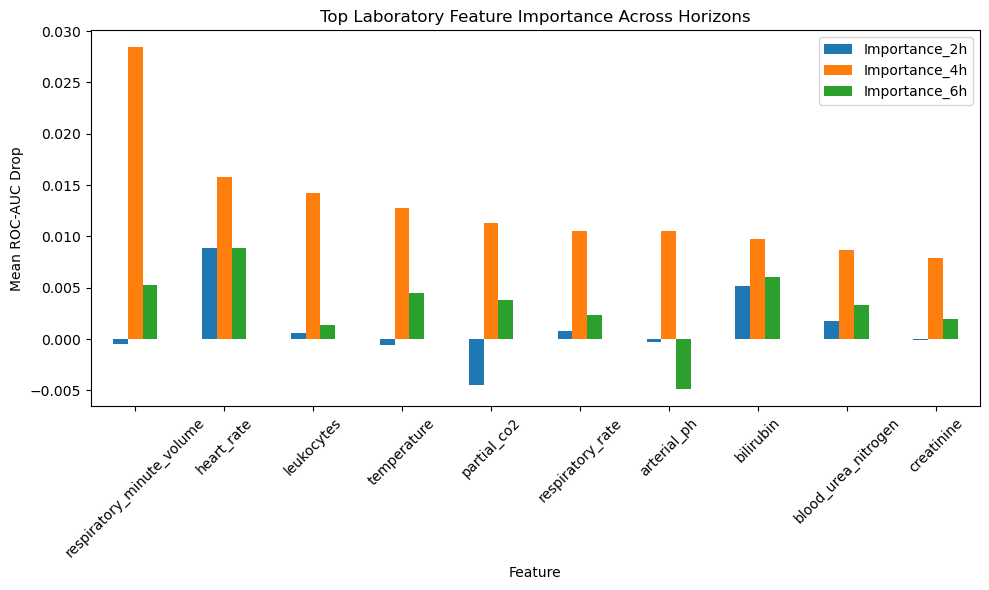

In [38]:
# Remove timestep for clinical comparison
comparison_labs = comparison_df[comparison_df["Feature"] != "timestep"]

top_features = (
    comparison_labs
    .sort_values("Importance_4h", ascending=False)
    .head(10)["Feature"]
)

plot_df = comparison_labs[comparison_labs["Feature"].isin(top_features)]

plot_df = plot_df.set_index("Feature")

plot_df[["Importance_2h", "Importance_4h", "Importance_6h"]]\
    .plot(kind="bar", figsize=(10,6))

plt.ylabel("Mean ROC-AUC Drop")
plt.title("Top Laboratory Feature Importance Across Horizons")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Laboratory Feature Importance Across Horizons

The bar plot shows how feature importance shifts across 2h, 4h, and 6h prediction windows (excluding timestep).

- Respiratory_minute_volume peaks at 4h, suggesting mid-window respiratory instability.
- Lactate gains prominence closer to onset (2h and 6h), reflecting metabolic stress.
- Heart_rate contributes consistently across horizons.
- Inflammatory markers (leukocytes, temperature) are most relevant at 4h.

Overall, importance redistributes over time, indicating evolving multi-system involvement in sepsis progression.

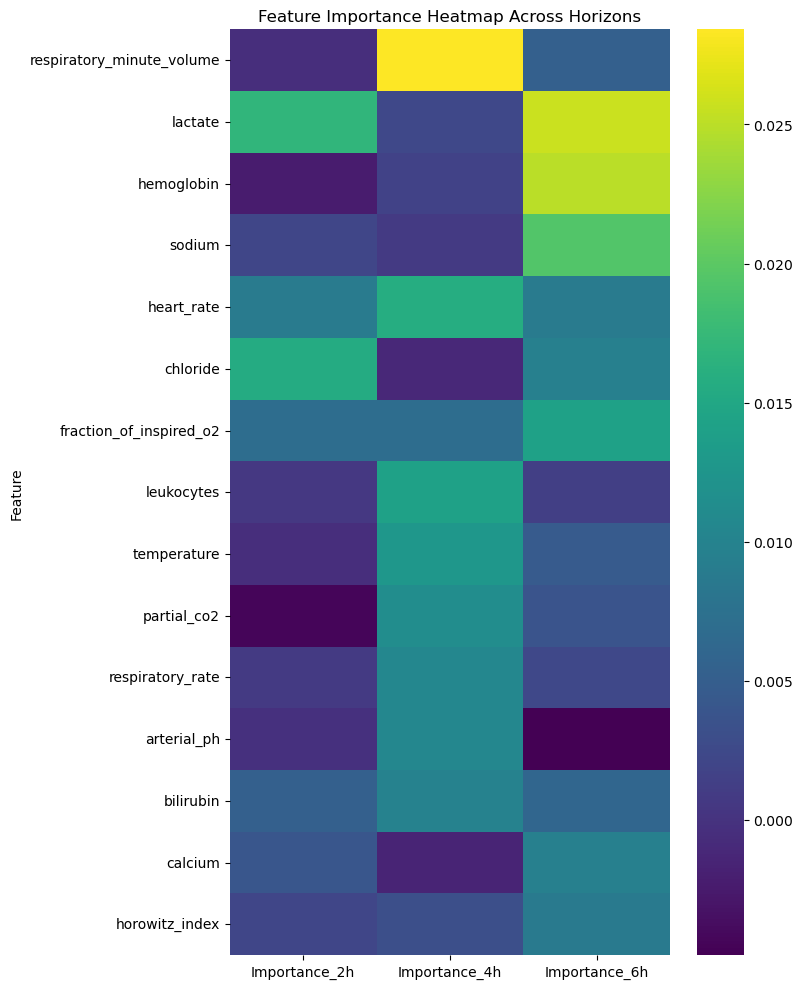

In [39]:
import seaborn as sns

heatmap_df = comparison_labs.set_index("Feature")[
    ["Importance_2h", "Importance_4h", "Importance_6h"]
]

# Optional: focus on top 15 by max importance
heatmap_df = heatmap_df.loc[
    heatmap_df.max(axis=1).sort_values(ascending=False).head(15).index
]

plt.figure(figsize=(8,10))
sns.heatmap(
    heatmap_df,
    cmap="viridis",
    annot=False
)

plt.title("Feature Importance Heatmap Across Horizons")
plt.tight_layout()
plt.show()

## Heatmap of Feature Importance Across Horizons

The heatmap highlights temporal shifts in laboratory relevance.

- 6h: Metabolic and oxygenation markers (lactate, hemoglobin, sodium) dominate.
- 4h: Respiratory and inflammatory features peak.
- 2h: Acute metabolic and hemodynamic signals strengthen.

No laboratory feature (excluding timestep) dominates consistently, supporting a dynamic, multi-system progression toward sepsis onset.

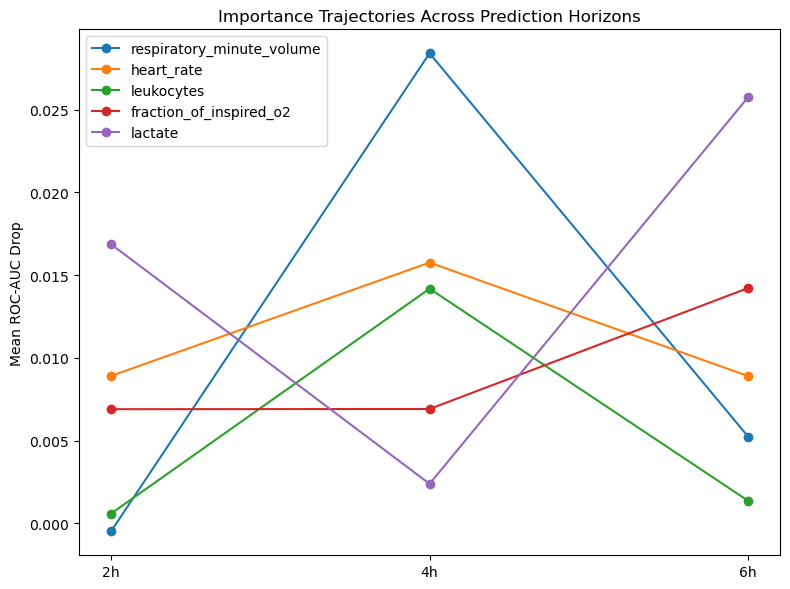

In [40]:
selected = ["lactate", "heart_rate", "respiratory_minute_volume", 
            "leukocytes", "fraction_of_inspired_o2"]

trajectory_df = comparison_labs[
    comparison_labs["Feature"].isin(selected)
]

plt.figure(figsize=(8,6))

for _, row in trajectory_df.iterrows():
    plt.plot(
        ["2h", "4h", "6h"],
        [row["Importance_2h"], row["Importance_4h"], row["Importance_6h"]],
        marker="o",
        label=row["Feature"]
    )

plt.ylabel("Mean ROC-AUC Drop")
plt.title("Importance Trajectories Across Prediction Horizons")
plt.legend()
plt.tight_layout()
plt.show()

## Feature Importance Trajectories Across Horizons

The trajectory plot illustrates how selected laboratory features evolve in importance across 2h, 4h, and 6h windows.

- Respiratory_minute_volume peaks at 4h, suggesting mid-window respiratory instability.
- Lactate increases strongly at 6h and remains relevant at 2h, reflecting metabolic stress.
- Leukocytes peak at 4h, consistent with inflammatory escalation.
- Heart_rate shows stable contribution across horizons.
- Fraction_of_inspired_o2 increases toward 6h, indicating growing oxygenation relevance.

These trajectories support a dynamic progression from metabolic imbalance (6h), to inflammatory and respiratory escalation (4h), to acute deterioration closer to onset (2h).

## Section 06 — Summary

Permutation importance revealed that sepsis prediction relies on distributed multi-system signals rather than a small dominant subset of laboratories.

Across horizons:
- 6h prediction emphasized metabolic and oxygenation markers (e.g., lactate, hemoglobin, sodium).
- 4h prediction highlighted respiratory and inflammatory features.
- 2h prediction strengthened acute metabolic and hemodynamic indicators.

Minimal subset experiments (4h) showed that restricting the model to the top 3–5 features led to a substantial drop in ROC-AUC (Δ ≈ 0.11–0.12), indicating that early sepsis detection is not compressible to a narrow laboratory panel.

Overall, feature importance patterns support a dynamic physiological progression toward sepsis onset, captured effectively by the LSTM’s temporal modeling.